In [29]:
include("../../src/WaterLily.jl")
# using WaterLily
WaterLily = Main.WaterLily;
using Plots; gr()
using StaticArrays
using Statistics

In [30]:
inside(a::AbstractArray) = CartesianIndices(map(ax->first(ax)+1:last(ax)-1,axes(a)))

function StaggerToCollocateVel!(u, uInside)
    uInside .= 0.0
    uInside[:,:,1] = 0.5*(u[2:end-1,2:end-1,1]+u[3:end,2:end-1,1])
    uInside[:,:,2] = 0.5*(u[2:end-1,2:end-1,2]+u[2:end-1,3:end,2])
end

StaggerToCollocateVel! (generic function with 1 method)

In [31]:
function flood(f::Array;shift=(0.,0.),cfill=:RdBu_11,clims=(),levels=10,kv...)
    if length(clims)==2
        @assert clims[1]<clims[2]
        @. f=min(clims[2],max(clims[1],f))
    else
        clims = (minimum(f),maximum(f))
    end
    Plots.contourf(axes(f,1).+shift[1],axes(f,2).+shift[2],f',
        linewidth=0, levels=levels, color=cfill, clims = clims, 
        aspect_ratio=:equal; kv...)
end

addbody(x,y;c=:black) = Plots.plot!(Shape(x,y), c=c, legend=false)
function body_plot!(sim;levels=[0],lines=:black,R=inside(sim.flow.p))
    WaterLily.measure_sdf!(sim.flow.σ,sim.body,WaterLily.time(sim))
    contour!(sim.flow.σ[R]';levels,lines)
end

function sim_gif!(sim;duration=1,step=0.1,verbose=true,R=inside(sim.flow.p),
                    remeasure=false,plotbody=false,kv...)
    t₀ = round(WaterLily.sim_time(sim))
    uInside = sim.flow.u[2:end-1,2:end-1,:]*0.0
    @time @gif for tᵢ in range(t₀,t₀+duration;step)
        WaterLily.sim_step!(sim,tᵢ;remeasure)
        for I∈inside(sim.flow.σ)
            sim.flow.σ[I] = WaterLily.curl(3,I,sim.flow.u)*sim.L/sim.U
        end
        flood(sim.flow.σ[R]; kv...)
        # flood(sim.flow.p[R].-Statistics.mean(sim.flow.p[R]); kv...)
        # StaggerToCollocateVel!(sim.flow.u,uInside)
        # flood(sqrt.(sum(uInside.^2,dims=[3]))[:,:,1]; kv...)
        plotbody && body_plot!(sim)
        verbose && println("tU/L=",round(tᵢ,digits=4),
            ", Δt=",round(sim.flow.Δt[end],digits=3))
    end
end

sim_gif! (generic function with 1 method)

In [32]:
function circle(n,m,r,x0,y0,Ux,Uy;Re=250)
    radius = r
    U = √(Ux*Ux+Uy*Uy)
    U = ifelse(U<0.001,1,U)
    function SDF(xyz,t)
        xc = x0
        yc = y0
        x,y = @. (xyz-1.5)
        return sqrt.((mod.(x.-xc,n)-n/2).^2+(mod.(y.-yc,m)-m/2).^2) .- radius
    end
    function MAP(xyz,t)
        return xyz .- SA[5*Ux*t*U/radius, 5*Uy*t*U/radius]
    end
    body = WaterLily.AutoBody(SDF,MAP)
    return WaterLily.Simulation((n,m), (1,0), radius; U, ν=U*radius/Re, body,perdir=(2,)) # ,perdir=(2,)
end

circle (generic function with 2 methods)

In [33]:
function circle(n,m;Re=250,U=1)
    radius, center = m/8, m/2
    body_sdf = (x,t) -> √sum(abs2, x .- center) - radius
    body_map = (x,t) -> x .- 25*cos(0.5t*U/radius) 
    return WaterLily.Simulation((n,m), (0,0), radius; U, ν=U*radius/Re, body=WaterLily.AutoBody(body_sdf,body_map))
end

circle (generic function with 2 methods)

In [34]:
sim = circle(2^7,2^7,2^5,2^7,2^7,1,1.5)
# sim = circle(2^7,2^7,2^4,2^6,2^6+9,0.0,0.0)
# sim = circle(2^7,2^7,2^4,2^7,2^7,0,1)
#csim = circle(2^7,2^7)
# sim = hover()

Main.WaterLily.Simulation(1.8027756377319946, 32, 1, Main.WaterLily.Flow{2, Float64, Matrix{Float64}, Array{Float64, 3}, Array{Float64, 4}}([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 57.802561210691536 … 57.802561210691536 0.0; … ; 0.0 57.802561210691536 … 57.802561210691536 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 

 71.623648 seconds (273.67 M allocations: 13.600 GiB, 5.47% gc time, 8.88% compilation time)


┌ Info: Saved animation to /tmp/jl_rcB4LepWf6.gif
└ @ Plots /home/tyhuang/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_rcB4LepWf6.gif")
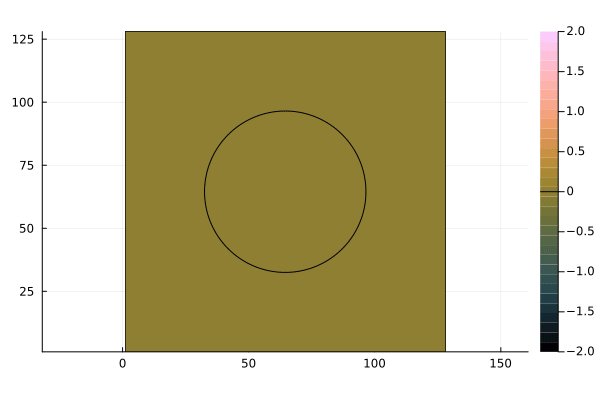

In [35]:
sim_gif!(sim,duration=20, step=0.1,clims=(-2,2),plotbody=true,verbose=false,levels=32,remeasure=true,cfill=:batlowK)

In [36]:
size(sim.flow.Δt)
sum(sim.flow.Δt[1:end])*sim.U/sim.L

20.084316523134927

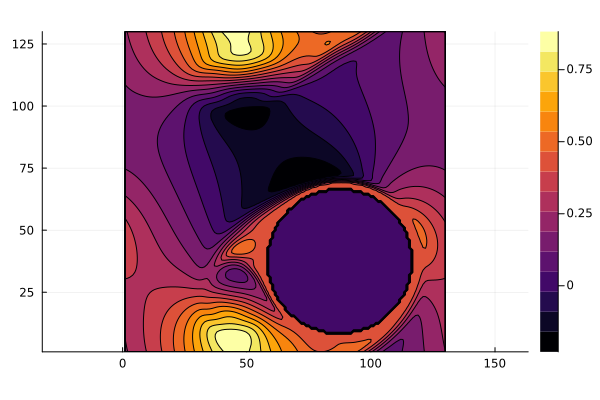

In [37]:
Plots.contourf(sim.flow.u[:,:,2],aspect_ratio=:equal)

In [38]:
aa = cumsum(sim.flow.Δt)[1:end-1]*sim.U/sim.L;

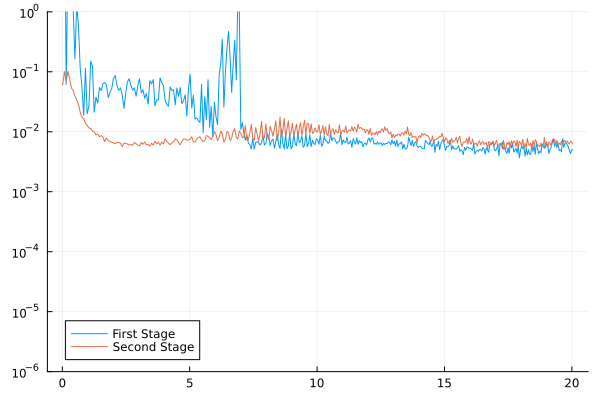

In [39]:
Plots.plot(aa,sim.pois.res[1:2:end],yscale=:log10,label="First Stage")
Plots.plot!(aa,sim.pois.res[2:2:end],yscale=:log10,label="Second Stage",legend=:bottomleft,ylimit=[1e-6,1])
# Plots.savefig(computationID*"_PoisRes.png")


In [40]:
WaterLily.size_u(sim.flow.u)

((130, 130), 2)

8.97883597883598
15.952380952380953


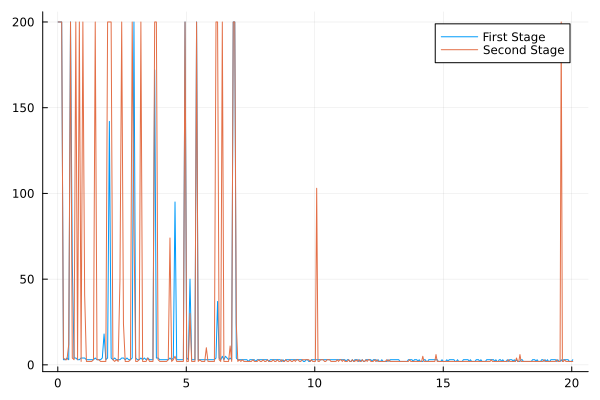

In [41]:
println(Statistics.mean(sim.pois.n[1:2:end]))
println(Statistics.mean(sim.pois.n[2:2:end]))
Plots.plot(aa,sim.pois.n[1:2:end],label="First Stage")
Plots.plot!(aa,sim.pois.n[2:2:end],label="Second Stage")
# Plots.plot!(ylimit=[0,10],xlimit=[50,300])
# Plots.savefig(computationID*"_PoisNum.png")



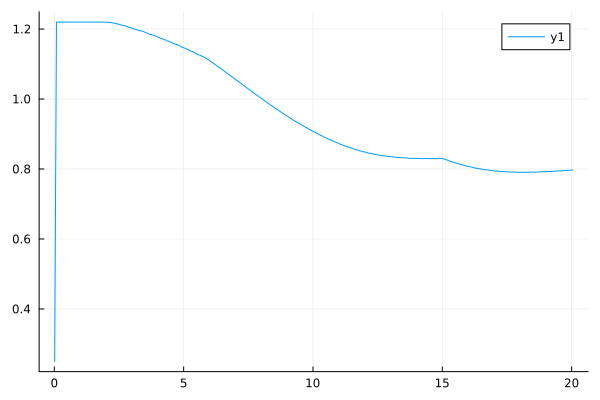

In [42]:

Plots.plot(aa,sim.flow.Δt[1:end-1])
# Plots.savefig(computationID*"_delT.png")
